# Predizione Prezzo Bitcoin
## Autori: Luca Morlino e Valerio Di Zio


In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Descrizione del problema
### Cos'è Bitcoin?
Il Bitcoin è una moneta virtuale creata nel 2009 da uno o più utenti con lo pseudonimo Satoshi Nakamoto. Diversamente dalle altre valute il Bitcoin non ha dietro una Banca centrale che distribuisce nuova moneta ma si basa fondamentalmente su due principi: un network di nodi, cioè di pc, che la gestiscono in modalità distribuita, peer-to-peer; e l'uso di una forte crittografia per validare e rendere sicure le transazioni.
### Obiettivo
L'obiettivo generale è quello di creare un algoritmo che preveda il valore di chiusura di bitcoin a inizio giornata.
Il bitcoin essendo una valuta a tutti gli effetti non ha un orario di apertura né uno di chiusura, per comodità il nostro dataset considera il valore di apertura a mezzanotte e il valore di chiusura a mezzanotte del giorno dopo.

## Estrazione dati
I dati relativi a BTC vengono scaricati dal servizio [Yahoo! Finance](https://it.finance.yahoo.com/).
Per fare ciò viene utilizzata la libreria yfinance che permette l'estrazione di dati in forma di oggetti Python facilmente interrogabili.
In particolare, la usiamo per ottenere i dati storici in forma di Dataframe Pandas

In [139]:
import yfinance

- Creiamo un oggetto Ticker che rappresenta uno specifico titolo o indice
- Nel nostro caso il simbolo del Bitcoin con il suo valore in Euro è BTC-EUR

In [140]:
btc = yfinance.Ticker("BTC-EUR")

- Utilizziamo il metodo history per ottenere i dati storici, partendo dal 1 gennaio 2015 fino a ieri.

In [141]:
from datetime import date

In [142]:
today = date.today().strftime("%Y-%m-%d")
data = btc.history(start="2015-01-02", end=today, actions=False)

Ad esempio, guardiamo i dati relativi agli ultimi 5 giorni. 

Ovviamente i dati odierni non sono presenti, saranno quelli che andremo a prevedere.

In [143]:
data.tail(5)

,Open,High,Low,Close,Volume
Date,,,,,
2022-06-09,28193.755859,28560.138672,28284.824219,28356.046875,20427057156
2022-06-10,28354.476562,28450.841797,27545.003906,27648.169922,28393158151
2022-06-11,27648.988281,27950.578125,26840.496094,26958.935547,25899776264
2022-06-12,26971.011719,27093.796875,25513.984375,25513.984375,32569266905
2022-06-13,25490.082031,25545.843750,21262.470703,21592.951172,65491720208



Andiamo a contare il numero di istanze ricavate

In [144]:
data.shape[0]

2721

## Features
Il nostro dataset ha 5 features:
- Open: è il valore in euro di un singolo bitcoin all'orario di apertura
- High: è il valore massimo in euro raggiunto durante la giornata
- Low: è il valore minimo in euro raggiunto durante la giornata
- Close: è il valore in euro di un singolo bitcoin all'orario di chiusura
- Volume: il volume di trading indica (nel nostro caso) il valore in euro di bitcoin scambiati durante la giornata

Per comodità estraiamo una serie per ciascuna colonna, per potersi riferire ad esse con un unico nome.

In [145]:
open = data["Open"]
high = data["High"]
low = data["Low"]
close = data["Close"]
volume = data["Volume"]

## Rappresentazione dei dati

Possiamo tracciare il grafico dell'andamento del prezzo, basandoci sulla feature "Open".

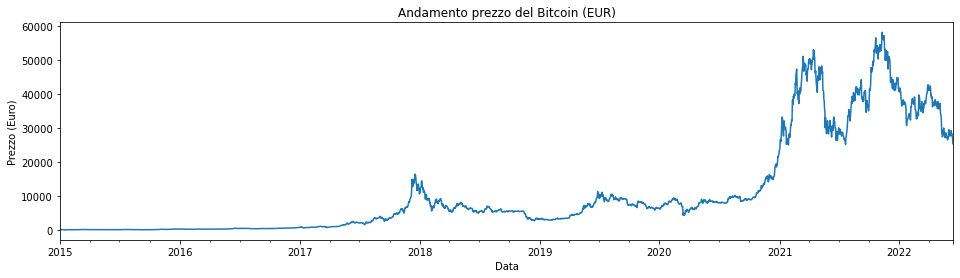

In [146]:
open.plot(figsize=(16,4))
plt.title("Andamento prezzo del Bitcoin (EUR)")
plt.xlabel("Data")
plt.ylabel("Prezzo (Euro)");

Utilizzando la libreria plotly è possibile visualizzare in un unico grafico 4 features (Open, High, Low, Close)

In [147]:
import plotly.graph_objects as go

In [148]:
candlestick = go.Candlestick(
                            x=data.index,
                            open=data['Open'],
                            high=data['High'],
                            low=data['Low'],
                            close=data['Close']
                            )


Il grafico è rappresentato mediante l'utilizzo di Candele, queste ultime rappresentano l'andamento del prezzo di una giornata.

<img src="candlestick.jpeg" alt="Candlestick" style="width:700px;"/>


In [149]:
from ipywidgets.widgets import interact
from datetime import timedelta

Ricaviamo la data relativa a 50 giorni fa

In [150]:
DD = timedelta(days=50)
earlier = date.today() - DD
earlier_str = earlier.strftime("%Y-%m-%d")

In [151]:


@interact(ymin=(0,60000,1000), ymax=(0,50000,1000))
def plot_candlestick(ymin=20000, ymax=40000):    
    fig = go.Figure(data=[candlestick])
    fig.update_layout(
        width=1000, height=700,
        title="Andamento prezzo Bitcoin Candlestick",
        yaxis_title='Prezzo (EURO)'
    )
    fig.update_xaxes(type="date", range=[earlier_str, today])
    fig.update_yaxes(range=[ymin,ymax])
    fig.show()

interactive(children=(IntSlider(value=20000, description='ymin', max=60000, step=1000), IntSlider(value=40000,…

Mostriamo ora alcune statistiche generali raggruppate per anno come:
- Media
- Deviazione Standard
- Min e Max
- Quartili


In [152]:
hlm = (high + low) / 2
hlm.groupby(hlm.index.year).describe()

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2015,365.0,246.160603,56.460048,167.797157,208.746437,224.089561,259.491707,424.535583
2016,366.0,514.521664,133.696362,334.301727,389.311001,516.306091,599.553146,925.023682
2017,365.0,3423.368238,3361.474391,744.576721,1119.535339,2281.081543,3771.968018,16625.953613
2018,365.0,6370.879611,1915.447679,2859.214111,5570.006348,5812.128174,7095.658203,14331.975098
2019,365.0,6611.505284,2378.373599,3008.023071,4043.200562,6979.854004,8610.137695,11237.593750
2020,366.0,9604.105389,3304.767447,4463.527954,8029.480408,8710.522217,9805.435303,23380.625977
2021,365.0,40095.692624,8737.824810,23983.438477,31245.380859,40675.902344,47296.929688,58211.095703
2022,164.0,35081.329953,4436.567076,23404.157227,32589.968506,36538.904297,37790.444336,43156.531250


## Prevedere il valore di chiusura a inizio giornata

La variabile da predire è la features "Close" relativa alla data odierna.

In [153]:
y = close

`high`, `low`, `volume` non possono essere utilizzate in quanto il loro valore non è noto a inizio giornata.
Attualmente l'unica feature utilizzabile è il valore `open`.

In [154]:
features = {"Open" : open}
X = pd.DataFrame(features)
X

,Open
Date,
2015-01-01,264.909882
2015-01-02,259.870117
2015-01-03,262.393555
2015-01-04,234.307861
2015-01-05,221.901901
...,...
2022-06-09,28193.755859
2022-06-10,28354.476562
2022-06-11,27648.988281


Suddividiamo i dati in un training set e in un validation set con la funzione `train_test_split`.

In [155]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=False)

## Test 1: Regressione Lineare

Usandro training e validation set creati in precedenza addestriamo un modello di regressione lineare e calcoliamo R<sup>2</sup>.

In [156]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
model.score(X_val, y_val)

0.9935837627388451

Il punteggio R<sup>2</sup> del modello risulta molto alto. Questo è dovuto al fatto che i valore `Open` e `Close` sono molto correlati.

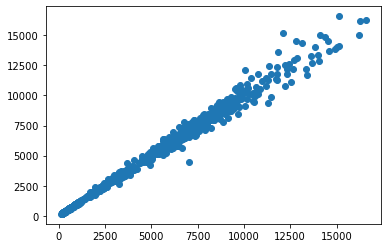

In [157]:
plt.scatter(X_train,y_train);

Per avere un riscontro dell'effetiva efficienza del modello calcoliamo il guadagno effettivo di un possibile investitore.

Per far ciò implementiamo un protocollo di trading che dati i valori di chiusura reali e predetti restituisce il guadagno effettivo.

**La cifra investita in questo caso è pari al valore di apertura che varia giornalmente**.

Definiamo la variabile differenza $\Delta_d=C_d-O_d$ tra il valore di chiusura giornaliero $C_d$ e di apertura $O_d$

In [158]:
delta = close - open

- Poniamo questo come il valore che **deve essere predetto** dal modello
- L'investitore agirà in base alla predizione $\hat{\Delta}_d$ in modo analogo a prima
  - se $\hat{\Delta}_d > 0$, acquista un titolo a inizio giornata e lo rivende alla fine
  - se $\hat{\Delta}_d < 0$, vende un titolo a inizio giornata e lo ricompra alla fine

### Definiamo alcune funzioni utili 

Possiamo definire una metrica "guadagno" per validare il modello, che restituisca il guadagno totale di un investitore che opera nel periodo a cui si riferisce il validation set

In [159]:
def gain(D, D_pred):
    growth = D_pred > 0
    decline = D_pred < 0
    return D[growth].sum() - D[decline].sum()

Il ROI (Return on investiment) esprime il guadagno di una o più operazioni in borsa in rapporto all'investimento iniziale.

In [160]:
def roi(D, D_pred):
    mean_open = open.reindex_like(D).mean()
    return gain(D, D_pred)/ mean_open

Definiamo anche una funzione che stampi le metriche di valutazione del modello

In [161]:
def print_eval(X, y, model):
    preds = model.predict(X)
    print("Gain: {:.2f}$".format(gain(y, preds)))
    print(" ROI: {:.3%}".format(roi(y, preds)))

La funzione `prepare_data` restituisce un Dataframe con le colonne indicate e una serie con i valori della variabile da predire corrispondenti alle righe selezionate del datafa

In [162]:
def prepare_data(features, delta):
    X = pd.DataFrame(features)
    X.dropna(inplace=True)
    y = delta.reindex_like(X)
    return X, y

In [164]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

Gain: -12790.97$
 ROI: -44.790%
